In [66]:
import gzip
import numpy as np

def images(f):
    with gzip.open(f, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        return images

def labels(f):
    with gzip.open(f, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels

In [76]:
training_images = images('train-images-idx3-ubyte.gz')
testing_images  = images('t10k-images-idx3-ubyte.gz')
training_labels = labels('train-labels-idx1-ubyte.gz')
testing_labels  = labels('t10k-labels-idx1-ubyte.gz')
print('Train: X=%s, y=%s' % (training_images.shape, training_labels.shape))
print('Test : X=%s, y=%s' % (testing_images.shape, testing_labels.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test : X=(10000, 28, 28), y=(10000,)


In [77]:
from sklearn.model_selection import train_test_split

# Change integers to 32-bit floating point numbers and normalize to range of 0-1
X_train = training_images.astype('float32')/255
X_test  = testing_images.astype('float32')/255

# Splitting the training dataset to train and validation datasets
X_train, X_val, y_train, y_val = train_test_split(X_train, training_labels, stratify=training_labels, test_size=0.2, random_state=42)

print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('val  : X=%s, y=%s' % (X_val.shape, y_val.shape))
print('Test : X=%s, y=%s' % (X_test.shape, testing_labels.shape))

Train: X=(48000, 28, 28), y=(48000,)
val  : X=(12000, 28, 28), y=(12000,)
Test : X=(10000, 28, 28), y=(10000,)


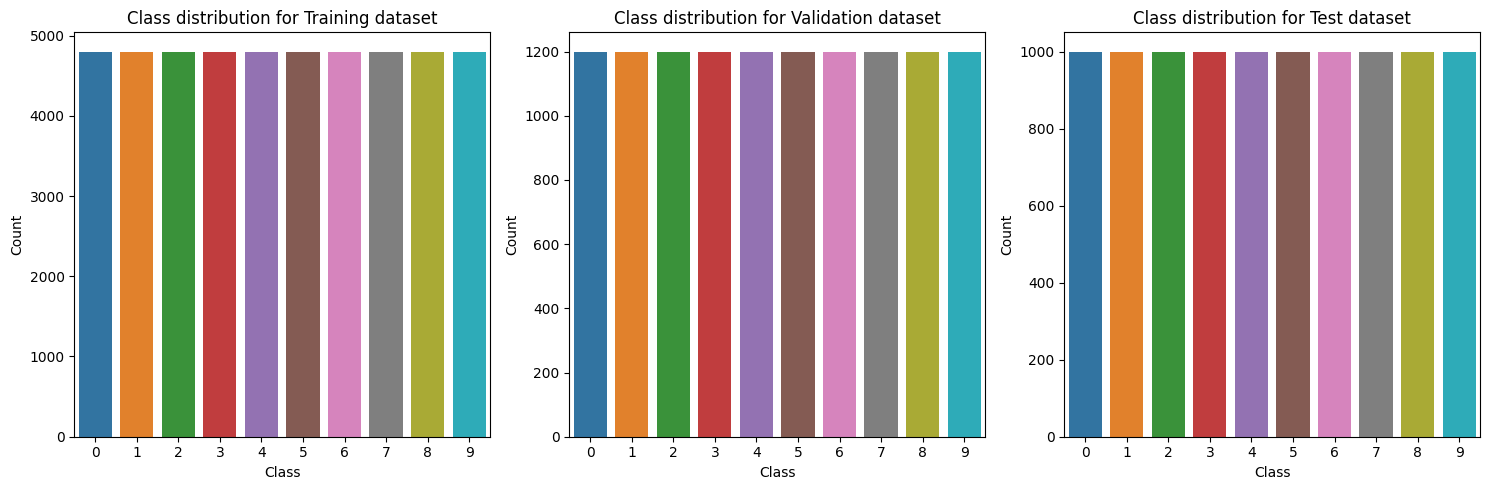

In [78]:
import seaborn as sns
import pandas as pd

# Create separate Series for each dataset
y_train_series = pd.Series(y_train)
y_val_series = pd.Series(y_val)
testing_labels_series = pd.Series(testing_labels)

# Calculate value counts for each dataset
class_counts_train = y_train_series.value_counts()
class_counts_val = y_val_series.value_counts()
class_counts_test = testing_labels_series.value_counts()

# Plotting class distributions for each dataset
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(x=class_counts_train.index, y=class_counts_train.values)
plt.title("Class distribution for Training dataset")
plt.xlabel("Class")
plt.ylabel("Count")

plt.subplot(1, 3, 2)
sns.barplot(x=class_counts_val.index, y=class_counts_val.values)
plt.title("Class distribution for Validation dataset")
plt.xlabel("Class")
plt.ylabel("Count")

plt.subplot(1, 3, 3)
sns.barplot(x=class_counts_test.index, y=class_counts_test.values)
plt.title("Class distribution for Test dataset")
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [79]:
# Flatten the images to 1-D by reshaping
X_train = X_train.reshape(48000,784)
X_val   = X_val.reshape(12000,784)
X_test  = X_test.reshape(10000,784)

print("Training matrix shape  :", X_train.shape)
print("Validation matrix shape:", X_val.shape)
print("Test matrix shape      :", X_test.shape)

Training matrix shape  : (48000, 784)
Validation matrix shape: (12000, 784)
Test matrix shape      : (10000, 784)


In [80]:
from sklearn.decomposition import PCA
pca_all = PCA(n_components = 784)
# Fit on training data
pca_fit = pca_all.fit_transform(X_train)
#percentage variance explained
ratio_variance = np.cumsum(pca_all.explained_variance_ratio_)
pca_fit.shape

(48000, 784)

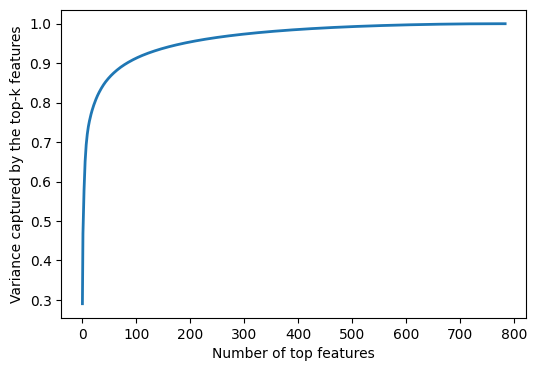

In [132]:
# Plot the PCA spectrum
plt.figure(figsize=(6, 4))
plt.plot(ratio_variance, linewidth=2)
plt.xlabel("Number of top features")
plt.ylabel("Variance captured by the top-k features")
plt.show()

In [82]:
pca = PCA(n_components=0.95)
pca.fit(X_train)
pca.n_components_

187

In [83]:
X_train_t = pca.transform(X_train)
X_val_t   = pca.transform(X_val)
X_test_t  = pca.transform(X_test)

X_train_i = pca.inverse_transform(X_train_t)
X_val_i   = pca.inverse_transform(X_val_t)
X_test_i  = pca.inverse_transform(X_test_t)


training_images         = X_train.reshape(48000,28,28)
reduced_training_images = X_train_i.reshape(48000,28,28)

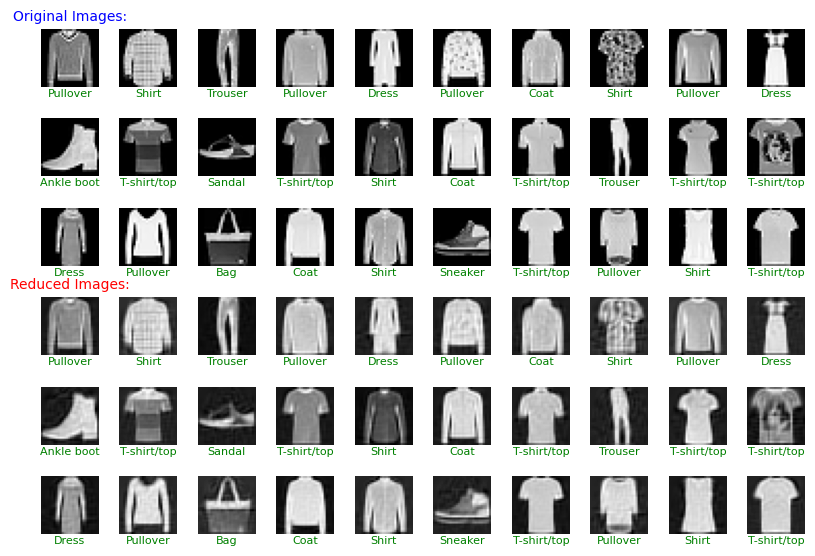

In [123]:
import matplotlib.pyplot as plt

# Define class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Randomly select 30 images from train dataset to visualize
num_images_to_display = 30
random_indexes = np.random.randint(0, X_train.shape[0], num_images_to_display)

# Create a figure with a grid of subplots
plt.figure(figsize=(8, 6))  # Adjust overall figure size

for i, index in enumerate(random_indexes, 1):
    # Original image
    plt.subplot(6, 10, i)
    plt.imshow(training_images[index], cmap='gray', extent=[0, 1.5, 0, 1.5])
    if i == 1:
        # Set the title for the section
        plt.title("Original Images:", fontsize=10, color='blue')
    plt.axis('off')
    # Add the label below the image with adjusted position
    plt.text(0.75, -0.25, class_names[y_train[index]], ha='center', fontsize=8, color='green')

    # Reduced image
    plt.subplot(6, 10, i + num_images_to_display)
    plt.imshow(reduced_training_images[index], cmap='gray', extent=[0, 1.5, 0, 1.5])
    if i == 1:
        # Set the title for the section
        plt.title("Reduced Images:", fontsize=10, color='red')
    plt.axis('off')
    # Add the label below the image with adjusted position
    plt.text(0.75, -0.25, class_names[y_train[index]], ha='center', fontsize=8, color='green')

# Adjust the placement of the title
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [131]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

X_train_fnn = torch.tensor(X_train_t).float()
y_train_fnn = torch.tensor(y_train).long()
X_val_fnn   = torch.tensor(X_val_t).float()
y_val_fnn   = torch.tensor(y_val).long()
X_test_fnn  = torch.tensor(X_test_t).float()
y_test_fnn  = torch.tensor(testing_labels).long()

# Creating TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_fnn, y_train_fnn)
val_dataset   = TensorDataset(X_val_fnn, y_val_fnn)
test_dataset  = TensorDataset(X_test_fnn, y_test_fnn)

# Define the hyperparameters to tune
hyperparameters = {
    'num_hidden_layers': [1, 2, 3],
    'nodes_per_layer': [[187,64,10], [187,64,32,10], [187,64,32,16,10]],
    'activation_function': ['relu', 'tanh', 'leaky_relu'],
    'learning_rate': [0.001, 0.01, 0.1],
    'momentum': [0.0, 0.5, 0.9],
    'optimizer': ['Adam', 'SGD', 'RMSprop'],
    'batch_size': [32, 64, 128],
    'epochs': [10, 20, 30],
}

batch_size    = 32
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader    = DataLoader(val_dataset, batch_size=batch_size)
test_loader   = DataLoader(test_dataset, batch_size=batch_size)

# Define the Feed-Forward Neural Network model
class FeedForwardNN(nn.Module):
    def __init__(self, num_hidden_layers, nodes_per_layer, activation_function, input_dim, output_dim):
        super().__init__()

        layers = []
        for i in range(num_hidden_layers):
            if i == 0:
                layers.append(nn.Linear(input_dim, nodes_per_layer))
            else:
                layers.append(nn.Linear(nodes_per_layer, nodes_per_layer))

            if activation_function == 'relu':
                layers.append(nn.ReLU())
            elif activation_function == 'tanh':
                layers.append(nn.Tanh())
            elif activation_function == 'leaky_relu':
                layers.append(nn.LeakyReLU(0.1))

        layers.append(nn.Linear(nodes_per_layer, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self, num_hidden_layers, nodes_per_layer, activation_function ):
        super().__init__()

        layers = []
        for i in range(num_hidden_layers):
            layers.append(nn.Linear(nodes_per_layer[i], nodes_per_layer[i+1]))

            if activation_function == 'relu':
                layers.append(nn.ReLU())
            elif activation_function == 'tanh':
                layers.append(nn.Tanh())
            elif activation_function == 'leaky_relu':
                layers.append(nn.LeakyReLU(0.1))
        layers.append(nn.Linear(nodes_per_layer[nodes_per_layer[]], nodes_per_layer[i+1]))

model = SimpleNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 30
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_train_preds = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train_preds += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    train_accuracy = correct_train_preds / len(train_dataset)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct_val_preds = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            running_val_loss += val_loss.item() * val_inputs.size(0)

            _, predicted = torch.max(val_outputs, 1)
            correct_val_preds += (predicted == val_labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    val_accuracy = correct_val_preds / len(val_dataset)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_fnn_model.pth')

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {epoch_train_loss:.4f}, '
          f'Validation Loss: {epoch_val_loss:.4f}, '
          f'Training Accuracy: {train_accuracy:.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}')

# Plotting training history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


<ipython-input-131-927b465be50e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_fnn = torch.tensor(y_train).long()
<ipython-input-131-927b465be50e>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_fnn   = torch.tensor(y_val).long()


Epoch [1/30], Training Loss: 1.7129, Validation Loss: 1.6178, Training Accuracy: 0.7596, Validation Accuracy: 0.8468


KeyboardInterrupt: ignored

In [127]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

# Load the trained FNN model
model = SimpleNN()  # Initialize your neural network class
model.load_state_dict(torch.load('best_fnn_model.pth'))  # Load the saved best model weights

# Set the model to evaluation mode
model.eval()

predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Calculate the confusion matrix and accuracy
conf_matrix = confusion_matrix(true_labels, predictions)
print("Classification report for FNN on test dataset :\n%s\n"
      % (metrics.classification_report(true_labels, predictions)))

print("\nConfusion Matrix on Test dataset:")
print(conf_matrix)

Classification report for FNN on test dataset :
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1000
           1       0.98      0.96      0.97      1000
           2       0.79      0.78      0.78      1000
           3       0.87      0.89      0.88      1000
           4       0.78      0.80      0.79      1000
           5       0.95      0.95      0.95      1000
           6       0.72      0.61      0.66      1000
           7       0.93      0.95      0.94      1000
           8       0.93      0.96      0.94      1000
           9       0.96      0.94      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



Confusion Matrix on Test dataset:
[[866   2  17  23   4   1  69   0  17   1]
 [  6 964   2  20   6   0   0   0   2   0]
 [ 18   3 776  13 108   0  74   0   8   0]
 [ 27  11   5 893  27   0  2

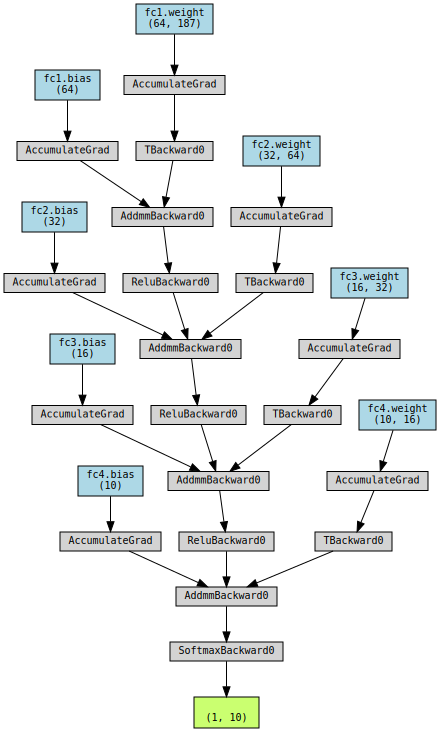

In [130]:
import torch
import torch.nn as nn
from torchviz import make_dot


# Initialize the model
model = SimpleNN()

# Create a random input (batch size = 1, input features = 187)
x = torch.randn(1, 187)

# Visualize the model architecture using torchviz
output = model(x)
make_dot(output, params=dict(model.named_parameters()))


In [129]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4133 sha256=fad537409dc31e4074b00dda7faf80fb38b50c9eec09fcb98ff995d9cc4f3986
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz
